***Installing torch***

In [ ]:
!pip3 install torch==1.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.7 MB/s eta 0:11:31tcmalloc: large alloc 1147494400 bytes == 0x55f0910be000 @  0x7f972b9c0615 0x55f05703c4cc 0x55f05711c47a 0x55f05703f2ed 0x55f057130e1d 0x55f0570b2e99 0x55f0570ad9ee 0x55f057040bda 0x55f0570b2d00 0x55f0570ad9ee 0x55f057040bda 0x55f0570af737 0x55f057131c66 0x55f0570aedaf 0x55f057131c66 0x55f0570aedaf 0x55f057131c66 0x55f0570aedaf 0x55f057041039 0x55f057084409 0x55f05703fc52 0x55f0570b2c25 0x55f0570ad9ee 0x55f057040bda 0x55f0570af737 0x55f0570ad9ee 0x55f057040bda 0x55f0570ae915 0x55f057040afa 0x55f0570aec0d 0x55f0570ad9ee
     |████████████████▌               | 1055.7 MB 1.4 MB/s eta 0:11:44tcmalloc: large alloc 1434370048 bytes == 0x55f0d5714000 @  0x7f972b9c0615 0x55f05703c4cc 0x55f05711c47a 0x55f05703f2ed 0x55f057130e1d 0x55f0570b2e99 0x55f0570ad9ee 0x55f057040bda 0x55f0570b2d00 0x55f0570ad9ee 0x55f057040bda 0x55f0570af737 0x55f057131c66 0x55f0570aed

In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from matplotlib import image
from skimage.util import random_noise

# PyTorch libraries and modules
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Check torch version**

In [ ]:
torch.__version__

'1.9.1+cu111'

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
#Mount GDrive for reading images stored in GDrive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Get image names from a GDrive directory

import os

path = '/content/gdrive/MyDrive/images/train'

imageNames = []

for i in os.scandir(path):
  imageNames.append(i.path)

imageNames

['/content/gdrive/MyDrive/images/train/100075.jpg',
 '/content/gdrive/MyDrive/images/train/103041.jpg',
 '/content/gdrive/MyDrive/images/train/122048.jpg',
 '/content/gdrive/MyDrive/images/train/105053.jpg',
 '/content/gdrive/MyDrive/images/train/12003.jpg',
 '/content/gdrive/MyDrive/images/train/100098.jpg',
 '/content/gdrive/MyDrive/images/train/109034.jpg',
 '/content/gdrive/MyDrive/images/train/108073.jpg',
 '/content/gdrive/MyDrive/images/train/113009.jpg',
 '/content/gdrive/MyDrive/images/train/130034.jpg',
 '/content/gdrive/MyDrive/images/train/113044.jpg',
 '/content/gdrive/MyDrive/images/train/134052.jpg',
 '/content/gdrive/MyDrive/images/train/104022.jpg',
 '/content/gdrive/MyDrive/images/train/135037.jpg',
 '/content/gdrive/MyDrive/images/train/113016.jpg',
 '/content/gdrive/MyDrive/images/train/126039.jpg',
 '/content/gdrive/MyDrive/images/train/134008.jpg',
 '/content/gdrive/MyDrive/images/train/112082.jpg',
 '/content/gdrive/MyDrive/images/train/118035.jpg',
 '/content/gd

In [ ]:
print(len(imageNames))

30


(321, 481, 3)


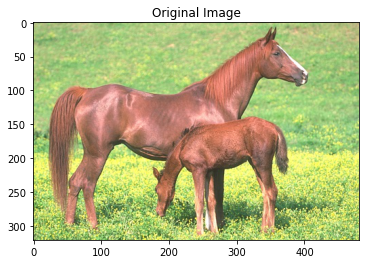

In [ ]:
# Read one image and display it
from matplotlib import image
imageNum = 10 # Eleventh image in the directory will be read

img = image.imread(imageNames[imageNum]) # Read image

plt.imshow(img)
plt.title("Original Image")
print(img.shape)

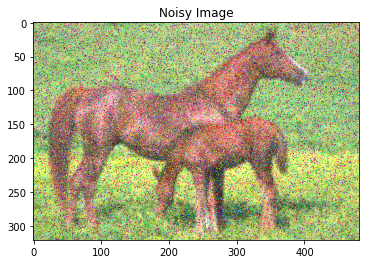

In [ ]:
#Lets check extent of our noise 
# Print image attributes
blur_img= cv2.blur(img, (5,5)) #Blurring image using appropriate kernel

# Add salt-and-pepper noise to the image.
noise_img = random_noise(blur_img, mode='s&p',amount=0.2)
 
# The above function returns a floating-point image
# on the range [0, 1], thus we changed it to 'uint8'
# and from [0,255]
noise_img = np.array(255*noise_img, dtype = 'uint8')


plt.imshow(noise_img)
plt.title("Noisy Image")
plt.show()

**Lets make 10000 patches of Noisy image as our input to CNN**

In [ ]:
from sklearn.feature_extraction import image
x_train = image.extract_patches_2d(noise_img, (27, 27), max_patches=10000)
print('Patches shape: {}'.format(x_train.shape))

Patches shape: (10000, 27, 27, 3)


In [ ]:
x_train = x_train / 255
x_train = x_train.astype('float32')

In [ ]:
x_train = np.array(x_train)
print(type(x_train))

<class 'numpy.ndarray'>


**Targeted output preparation, patches of clean image to get central pixel.**

In [ ]:
from sklearn.feature_extraction import image
imgpatch = image.extract_patches_2d(img, (27, 27), max_patches=10000)
print('Patches shape: {}'.format(imgpatch.shape))

Patches shape: (10000, 27, 27, 3)


**Get central pixel**

In [ ]:
cent_patch=[]
for i in range (len(imgpatch)):
  j= imgpatch[i, 13, 13, 0:3]
  cent_patch.append(j)

In [ ]:
y_train= np.array(cent_patch)
y_train = y_train / 255
y_train = y_train.astype('float32')
print(type(y_train))

<class 'numpy.ndarray'>


In [ ]:
y_train.shape
# # print(y_train[0].shape)
y_train= y_train.reshape(10000,1,1,3)
y_train.shape
# print(y_train[0])


(10000, 1, 1, 3)

In [ ]:
print(y_train[:5])


[[[[0.54509807 0.6        0.16470589]]]


 [[[0.67058825 0.8        0.5294118 ]]]


 [[[0.7647059  0.8980392  0.59607846]]]


 [[[0.827451   0.6        0.5921569 ]]]


 [[[0.5882353  0.7764706  0.44705883]]]]


**Lets keep 10% data in the validation set and the remaining in the training set.**

In [ ]:
from sklearn.model_selection import train_test_split
         
# create validation set
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((9000, 27, 27, 3), (9000, 1, 1, 3)), ((1000, 27, 27, 3), (1000, 1, 1, 3)))

In [ ]:
# converting training images into torch format
train_x = train_x.reshape(9000, 3, 27, 27)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.reshape(9000, 3, 1, 1)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([9000, 3, 27, 27]), torch.Size([9000, 3, 1, 1]))

In [ ]:
# converting validation images into torch format
val_x = val_x.reshape(1000, 3, 27, 27)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.reshape(1000, 3, 1, 1);
val_y = torch.from_numpy(val_y)
# val_y = torch.tensor(val_y, dtype= torch.long)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([1000, 3, 27, 27]), torch.Size([1000, 3, 1, 1]))

**Lets define model architecture**

In [ ]:
class NewNet(nn.Module):
  def __init__(self):
    super(NewNet,self).__init__()
    self.c1 = nn.Conv2d(3,8,9)       #kernel size for each layer is choosen such that
    # self.c2 = nn.conv2d(8,8,11)    # Out of last Cnn layer matches with our targeted output.
    self.p1 = nn.BatchNorm2d(8)
    self.c2 = nn.Conv2d(8,16,7)
    self.p2 = nn.BatchNorm2d(16)
    self.c3 = nn.Conv2d(16,32,5)
    self.p3 = nn.BatchNorm2d(32)
    self.c4 = nn.Conv2d(32,64,5)
    self.p4 = nn.BatchNorm2d(64)
    self.c5 = nn.Conv2d(64,128,3)
    self.p5 = nn.BatchNorm2d(128)
    self.c6 = nn.Conv2d(128,3,3)
    self.p6 = nn.BatchNorm2d(3)
    self.c7 = nn.Conv2d(3,3,1)
    self.drop = nn.Dropout2d(p=0.25)

  def forward(self,x):
    x = self.p1(F.relu(self.c1(x)))
    x = self.drop(x)
    x = self.p2(F.relu(self.c2(x)))
    x = self.p3(F.relu(self.c3(x)))
    x = self.drop(x)
    x = self.p4(F.relu(self.c4(x)))
    x = self.p5(F.relu(self.c5(x)))
    x = self.drop(x)
    x = self.p6(F.relu(self.c6(x)))
    
    x = self.c7(x)
    return x

test_model = NewNet().to(device)

**Sumary of our model**

In [ ]:
from torchsummary import summary
summary(test_model, (3,27,27))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 19, 19]           1,952
       BatchNorm2d-2            [-1, 8, 19, 19]              16
         Dropout2d-3            [-1, 8, 19, 19]               0
            Conv2d-4           [-1, 16, 13, 13]           6,288
       BatchNorm2d-5           [-1, 16, 13, 13]              32
            Conv2d-6             [-1, 32, 9, 9]          12,832
       BatchNorm2d-7             [-1, 32, 9, 9]              64
         Dropout2d-8             [-1, 32, 9, 9]               0
            Conv2d-9             [-1, 64, 5, 5]          51,264
      BatchNorm2d-10             [-1, 64, 5, 5]             128
           Conv2d-11            [-1, 128, 3, 3]          73,856
      BatchNorm2d-12            [-1, 128, 3, 3]             256
        Dropout2d-13            [-1, 128, 3, 3]               0
           Conv2d-14              [-1, 

**Parameter Initialization**

In [ ]:
# defining the model
model = NewNet().to(device)

# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)  # Adam Optamizer

criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

NewNet(
  (c1): Conv2d(3, 8, kernel_size=(9, 9), stride=(1, 1))
  (p1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1))
  (p2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (p3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (p4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (p5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c6): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1))
  (p6): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c7): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (drop): Dropout2d(p=0.25, inplace=False)
)


**Lets train our model**

In [ ]:
#Lets define function to train the model
def train(epoch):
  model.train()
  tr_loss=0
  #get training set
  x_train_, y_train_=  Variable(train_x), Variable(train_y)
  
  #get validation set
  x_val, y_val = Variable(val_x), Variable(val_y)

  #For GPU
  if torch.cuda.is_available():
    x_train_ = x_train_.cuda()
    y_train_ = y_train_.cuda()
    x_val = x_val.cuda()
    y_val = y_val.cuda()

  # clearing the Gradients of the model parameters
  optimizer.zero_grad()
    
  # prediction for training and validation set
  output_train = model(x_train_)
  output_val = model(x_val)

  # computing the training and validation loss
  loss_train = criterion(output_train, y_train_)
  loss_val = criterion(output_val, y_val)
  train_losses.append(loss_train)
  val_losses.append(loss_val)

  # computing the updated weights of all the model parameters
  loss_train.backward()
  optimizer.step()
  tr_loss = loss_train.item()

  if epoch%2 ==0:
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

**Training for 25 epochs**

In [ ]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
  train(epoch)

Epoch :  1 	 loss : tensor(0.4380, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  3 	 loss : tensor(0.1250, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  5 	 loss : tensor(0.0612, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  7 	 loss : tensor(0.0372, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  9 	 loss : tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  11 	 loss : tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  13 	 loss : tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  15 	 loss : tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  17 	 loss : tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  19 	 loss : tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  21 	 loss : tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  23 	 loss : tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward>)
Epoch :  25 	 loss : tensor(0.0280, device='c

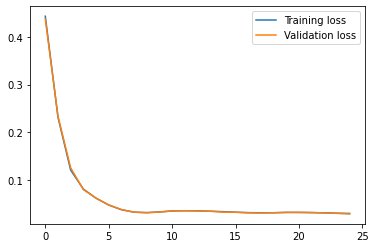

In [ ]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
#SAVING FINAL MODEL

PATH2 = './Finalcnn.pth'
torch.save(model.state_dict(), PATH2)

In [ ]:
#loading ptocedure from path
model = NewNet().to(device)
model.load_state_dict(torch.load(PATH2))

<All keys matched successfully>

**Lets see how our  model has performed by calculating MSE on training and validation set**

In [ ]:
# prediction for training set
with torch.no_grad():
    output = model(train_x.cuda())
predictions = output.cpu()

# accuracy on training set
print("MSE is: ", criterion(train_y, predictions))

MSE is:  tensor(0.0287)


In [ ]:
# prediction for training set
with torch.no_grad():
    output = model(val_x.cuda())
predictions = output.cpu()

# accuracy on training set
print("MSE is: ", criterion(val_y, predictions))

MSE is:  tensor(0.0283)


**Prepare data that model has never seen**

(321, 481, 3)


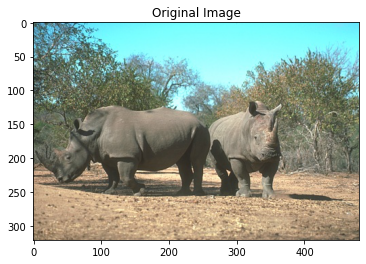

In [ ]:
# Read one image and display it
from matplotlib import image
imageNum = 17 # Eleventh image in the directory will be read

img = image.imread(imageNames[imageNum]) # Read image

plt.imshow(img)
plt.title("Original Image")
print(img.shape)

In [ ]:
img[200, 400]

array([128, 124, 113], dtype=uint8)

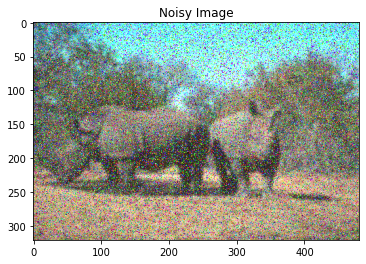

In [ ]:
#Lets check extent of our noise 
# Print image attributes
blur_img= cv2.blur(img, (5,5)) #Blurring image using appropriate kernel

# Add salt-and-pepper noise to the image.
noise_img = random_noise(blur_img, mode='s&p',amount=0.2)
 
# The above function returns a floating-point image
# on the range [0, 1], thus we changed it to 'uint8'
# and from [0,255]
noise_img = np.array(255*noise_img, dtype = 'uint8')


plt.imshow(noise_img)
plt.title("Noisy Image")
plt.show()

**Prepare x_test**

In [ ]:
#Get 10000 patches
from sklearn.feature_extraction import image
x_test = image.extract_patches_2d(noise_img, (27, 27), max_patches= 10000)
print('Patches shape: {}'.format(x_train.shape))

Patches shape: (10000, 27, 27, 3)


In [ ]:
# x_test = x_test / 255
x_test = x_test.astype('float32')

In [ ]:
x_test = np.array(x_train)
print(type(x_test))

<class 'numpy.ndarray'>


In [ ]:
# converting testing images into torch format
x_test = x_test.reshape(10000, 3, 27, 27)
x_test  = torch.from_numpy(x_test)
x_test= x_test.float()

# shape of testing data
x_test.shape

torch.Size([10000, 3, 27, 27])

**Prepare Y_test**

In [ ]:
from sklearn.feature_extraction import image
ypatch = image.extract_patches_2d(img, (27, 27), max_patches= 10000)
print('Patches shape: {}'.format(x_train.shape))

Patches shape: (10000, 27, 27, 3)


In [ ]:
cent_patch=[]
for i in range (len(ypatch)):
  j= imgpatch[i, 13, 13, 0:3]
  cent_patch.append(j)

In [ ]:
y_test= np.array(cent_patch)
y_test = y_test / 255
y_test = y_test.astype('float32')
print(type(y_test))

<class 'numpy.ndarray'>


In [ ]:
# converting testing images into torch format
y_test = y_test.reshape(10000, 3, 1, 1)
y_test  = torch.from_numpy(y_test)
y_test= y_test.float()

# shape of testing data
y_test.shape

torch.Size([10000, 3, 1, 1])

**Lets fit new data x_test to model**

In [ ]:
test_out = model(x_test.cuda())

In [ ]:
# accuracy on test set
test_out= test_out.cpu()
print("Model MSE on new data is: ", criterion(y_test, test_out))

Model MSE on new data is:  tensor(0.0286, grad_fn=<MseLossBackward>)


**MSE is decent for a CNN Model which is expected to perform better for image regression.**